In [6]:
# Importing packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pprint import pprint

from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import umap.umap_ as umap

In [7]:
# loading dataset and handle a subset of it
path_2 = "datasets/diabetes_binary_health_indicators_BRFSS2015.csv"
path_3 = "datasets/diabetes_012_health_indicators_BRFSS2015.csv"

df = pd.read_csv(path_2)
df_t = pd.read_csv(path_3)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


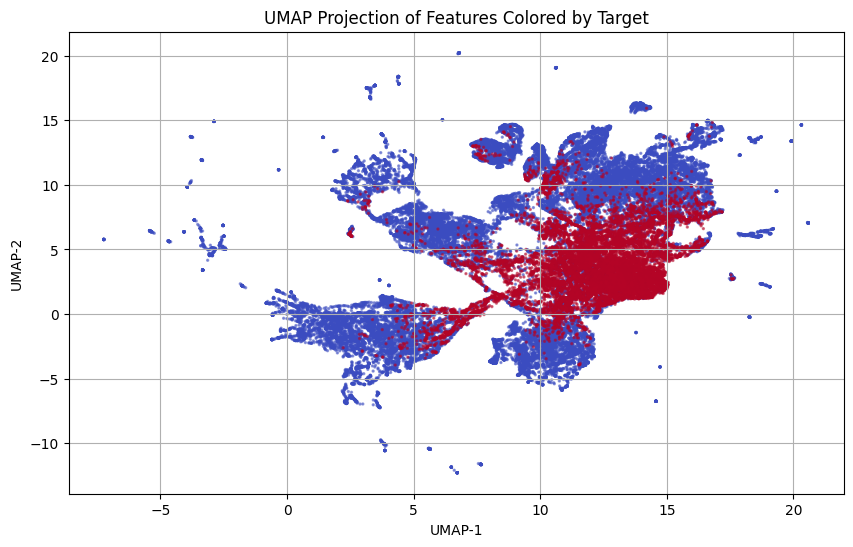

RF classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93     35502
         1.0       0.75      0.92      0.83     13342

    accuracy                           0.90     48844
   macro avg       0.86      0.90      0.88     48844
weighted avg       0.91      0.90      0.90     48844

Confusion Matrix:
[[31454  4048]
 [ 1030 12312]]


In [9]:
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

undersample2 = RandomUnderSampler(sampling_strategy={0.0: 60000}, random_state=17)
X_und, y_und = undersample2.fit_resample(X, y)

smote2 = SMOTEENN(random_state=42, sampling_strategy=0.7, n_jobs=-1)
X_und, y_und = smote2.fit_resample(X_und, y_und)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_und)

pca = PCA(n_components=5) 

X_scaled = pca.fit_transform(X_scaled)

# Apply UMAP for 2D projection
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_und, cmap='coolwarm', s=2, alpha=0.5)
plt.title("UMAP Projection of Features Colored by Target")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

# Define Nystroem transformer (approximates RBF kernel)
nystroem = Nystroem(
    kernel='rbf',
    gamma=0.1,          # Match this to your SVC's gamma
    n_components=1000,  # Number of landmark points (trade-off: speed vs. accuracy)
    random_state=42
)

# Combine with LinearSVC (faster than SVC)
svm_linear = LinearSVC(
    C=1.0,              # Regularization parameter (match your SVC's C)
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

# Create a pipeline
pipeline = make_pipeline(
    StandardScaler(),   # Always scale data first!
    nystroem,
    svm_linear
)
# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_rf = cross_val_predict(pipeline, X_scaled, y_und, cv=cv, n_jobs=-1)
print("RF classification Report:")
print(classification_report(y_und, y_pred_rf))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_und, y_pred_rf)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
X = df_t.drop(columns=['Diabetes_012'])
y = df_t['Diabetes_012']

min_class_count = y.value_counts().min()

sampling_strategy={0.0: 35346, 1.0: min_class_count, 2.0: 35346}
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy,random_state=17)

X_und, y_und = undersample.fit_resample(X, y)

print("[Ternary] After Undersampling:", Counter(y))

smote2 = SMOTEENN(random_state=42, n_jobs=-1)
X_und, y_und = smote2.fit_resample(X_und, y_und)

print("[Ternary] After Undersampling:", Counter(y_und))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_und)

pca = PCA(n_components=5) 

X_scaled = pca.fit_transform(X_scaled)

# Apply UMAP for 2D projection
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_und, cmap='coolwarm', s=2, alpha=0.5)
plt.title("UMAP Projection of Features Colored by Target")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()

# Define Nystroem transformer (approximates RBF kernel)
nystroem = Nystroem(
    kernel='rbf',
    gamma=0.1,          # Match this to your SVC's gamma
    n_components=1000,  # Number of landmark points (trade-off: speed vs. accuracy)
    random_state=42
)

# Combine with LinearSVC (faster than SVC)
svm_linear = LinearSVC(
    C=1.0,              # Regularization parameter (match your SVC's C)
    random_state=42,
    dual=False, 
    multi_class='ovr'
)

# Create a pipeline
pipeline = make_pipeline(
    StandardScaler(),   # Always scale data first!
    nystroem,
    svm_linear
)
# Define stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred_rf = cross_val_predict(pipeline, X_scaled, y_und, cv=cv, n_jobs=-1)
print("RF classification Report:")
print(classification_report(y_und, y_pred_rf))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_und, y_pred_rf)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

[Ternary] After Undersampling: Counter({0.0: 213703, 2.0: 35346, 1.0: 4631})
